In [1]:
import s3fs
import xarray as xr
import numpy as np

Reading the zarr HRRR data from the AWS registry: https://registry.opendata.aws/noaa-hrrr-pds/

Zarr is a cloud optimized format. The reading is much faster, but more work is required to get all the model levels from this registry as is done in the previous notebook. Specifically, one would have to separately read all the model levels from various urls. Moreover, the zarr files only go back to 2018 and are not being backward processed (see this [schedule](https://mesowest.utah.edu/html/hrrr/) table).

Here are some useful references for reading the HRRR data in zarr format: https://github.com/blaylockbk/Herbie/discussions/8

The main tutorial I used from that list is [here](https://github.com/ktyle/python_pangeo_ams2021/blob/main/notebooks/03_Pangeo_HRRR.ipynb). Since we are not going to use `zarr` due to its limited backward temporal coverage, we are simpy going to provide a brief discussions for our references here. We note this was not in vain as it helped geo-referencing the `grib2` datasets.

In [2]:
metadata_url = 's3://hrrrzarr/prs/20180717/20180717_05z_anl.zarr/100mb/HGT'
data_url = 's3://hrrrzarr/prs/20180717/20180717_05z_anl.zarr/100mb/HGT/100mb/'

fs = s3fs.S3FileSystem(anon=True)    
ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in [metadata_url, data_url]], engine='zarr')
ds

<xarray.Dataset>
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    HGT                      (projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

For each level, one would want to manaully add this information.

In [3]:
ds = ds.expand_dims(dim={'level': [100]})

In [4]:
ds.rio.crs

As done in the previous notebook, we have to add a CRS.

In [5]:
from pyproj import CRS
crs = CRS.from_cf({"grid_mapping_name": "lambert_conformal_conic", 
                   "longitude_of_central_meridian":-97.5,
                   "latitude_of_projection_origin": 38.5,
                   "standard_parallel":38.5})

In [6]:
ds.rio.transform()


Affine(3000.0, 0.0, -2699020.1425219304,
       0.0, 3000.0, -1588806.1525566636)

In [7]:
ds['HGT'] = ds['HGT'].astype(np.float32)
ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds.rio.write_crs(crs, inplace=True)
ds['HGT'].rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'HGT' (level: 1, y: 1059, x: 1799)>
dask.array<astype, shape=(1, 1059, 1799), dtype=float32, chunksize=(1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * level        (level) int64 100
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
    spatial_ref  int64 0
Attributes:
    GRIB_PARAM:   [2, 0, 3, 5]
    coordinates:  forecast_period forecast_reference_time time pressure
    long_name:    100mb/HGT
    units:        m
    _FillValue:   nan

In [8]:
ds2 = ds.rio.reproject(CRS.from_epsg(4326))
ds2

<xarray.Dataset>
Dimensions:                  (x: 2267, y: 979, level: 1)
Coordinates:
  * x                        (x) float64 -134.0 -134.0 -133.9 ... -61.03 -61.0
  * y                        (y) float64 52.61 52.58 52.54 ... 21.16 21.13 21.1
  * level                    (level) int64 100
    spatial_ref              int64 0
Data variables:
    HGT                      (level, y, x) float32 nan nan nan ... nan nan nan
    forecast_period          (level) timedelta64[ns] 00:00:00
    forecast_reference_time  (level) datetime64[ns] 2018-07-17T05:00:00
    pressure                 (level) float64 5e+03
    time                     (level) datetime64[ns] 2018-07-17T05:00:00

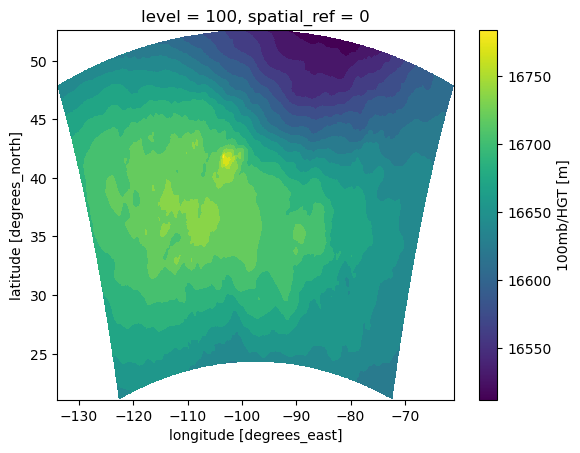

In [9]:
ds2['HGT'].plot()